# Infer ***lysosome*** - part 4️⃣

--------------

## OBJECTIVE: ✅ Infer sub-cellular component ***lysosome***  in order to understand interactome 



Dependencies:
The ***lysosome***  inference rely on the ***cytosol*** mask.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling, segmentation_union, size_filter
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    read_input_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff, 
                                                                    etree_to_dict, 
                                                                    save_parameters, 
                                                                    load_parameters, 
                                                                    export_ndarray)
from infer_subc_2d.utils.img import *

from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )          

from infer_subc_2d.organelles.soma import infer_soma
from infer_subc_2d.organelles.nuclei import infer_nuclei
from infer_subc_2d.organelles.cytosol import infer_cytosol

%load_ext autoreload
%autoreload 2

test_img_n = TEST_IMG_N

---------------------

# IMAGE PROCESSING Objective 4:  infer ***lysosome***

## summary of steps (Workflow #1 & #2)

INPUT
- channel  2
- cytosol mask

PRE-PROCESSING
-  smooth / remove noise

CORE-PROCESSING
- enhance two classes of "spots"
-  segment objects

POST-PROCESSING
  - filter objects

OUTPUT
- object ***lysosome*** 



------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [2]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [4]:
# # make sure we have removed Z
# if len(scale)>2:
#     scale = scale[1:]

## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [5]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 
img_2D = img_data[:,[optimal_Z],:,:].copy()


Now get the single "optimal" slice of all our organelle channels....

## get the inferred soma, nuclei and cytosol objects

(takes < 1 sec)

In [8]:

soma_mask =  infer_soma(img_2D) 

nuclei_object =  infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


... and visualize.

In [9]:
viewer = napari.Viewer()
viewer.add_image(soma_mask,
    scale=scale)
viewer.add_image(nuclei_object,
    scale=scale)
    


<Image layer 'nuclei_object' at 0x1673baca0>

In [10]:
viewer.add_image(cytosol_mask,
    scale=scale)    

<Image layer 'cytosol_mask' at 0x175a5deb0>

# WORKFLOW #1 

Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter LAMP1 [workflow](https://www.allencell.org/cell-observations/category/lamp1).  Examples sourced from: [Notebook](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/lookup_table_demo/playground_lamp1.ipynb) and [script](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/aicssegmentation/structure_wrapper/seg_lamp1.py)

## summary of steps

INPUT
- channel 1
- ***cytosol*** mask

PRE-PROCESSING
- contrast scale
- ne-noise and somoothe

CORE PROCESSING
- dot enhancement / segment
- filiment enhancement / segment

POST-PROCESSING
  - fill holes
  - remove small objects

OUTPUT
- ***lysosome*** object


### INPUT

In [11]:

###################
# INPUT
###################
raw_lyso    = img_2D[LYSO_CH].copy()


### PRE-PROCESSING

In [12]:
###################
# PRE_PROCESSING
###################

# Linear-ish smoothing
lysosomes = min_max_intensity_normalization( raw_lyso)

med_filter_size = 3   
structure_img_median = median_filter_slice_by_slice( lysosomes, size=med_filter_size  )

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(  structure_img_median,
                                                                                            sigma=gaussian_smoothing_sigma,
                                                                                            truncate_range = gaussian_smoothing_truncate_range )

struct_img = structure_img_smooth

### CORE PROCESSING

In [13]:
###################
# CORE_PROCESSING
###################
# dot and filiment enhancement - 2D

################################
## PARAMETERS for this step ##
s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
################################
bw_spot = dot_2d_slice_by_slice_wrapper(struct_img, s2_param)


################################
## PARAMETERS for this step ##
f2_param = [[1, 0.15]]
################################
bw_filament = filament_2d_wrapper(struct_img, f2_param)
bw = np.logical_or(bw_spot, bw_filament)



### POST-PROCESSING

> NOTE: we are using the 3D aicssegmentation functions which wrap `scipy.ndimage` functions with a single Z rather than the `scipy.ndimage` functions directly

In [14]:
###################
# POST_PROCESSING
###################

################################
## PARAMETERS for this step ##

fill_2d = True
fill_max_size = 25
hole_min = 0
################################

removed_holes = hole_filling(bw, hole_min ** 2, fill_max_size ** 2, fill_2d)


masked_img = apply_mask(removed_holes, cytosol_mask)

width = 3  
# cleaned_img = size_filter(removed_holes, # wrapper to remove_small_objects which can do slice by slice
#                                                          min_size= width**2, 
#                                                          method = "slice_by_slice" ,
#                                                          connectivity=1)

cleaned_img = size_filter_2D(masked_img, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= width ** 2, 
                                                         connectivity=1)


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [15]:

viewer.add_image(
    removed_holes,
    scale=scale
)
viewer.add_image(
    masked_img,
    scale=scale
)


<Image layer 'masked_img' at 0x17f9b8a30>

In [16]:

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img,
    scale=scale
)
viewer.add_image(
    structure_img_smooth,
    scale=scale
)

<Image layer 'structure_img_smooth' at 0x17fccddc0>

### DEFINE `infer_lysosomes` function

In [27]:
##########################
#  infer_LYSOSOMES
##########################
def _infer_lysosomes(in_img:  np.ndarray, cytosol_mask:  np.ndarray) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    cytosol_mask: np.ndarray
        mask of cytosol
 
    Returns:
    -------------
    lysosome_object
        mask defined extent of lysosome object
    """

    
    ###################
    # PRE_PROCESSING
    ###################     
    struct_img = min_max_intensity_normalization(in_img[LYSO_CH].copy() )

    med_filter_size = 3   
    struct_img = median_filter_slice_by_slice( 
                                                                    struct_img,
                                                                    size=med_filter_size  )

    gaussian_smoothing_sigma = 1.34
    gaussian_smoothing_truncate_range = 3.0
    struct_img = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                        truncate_range = gaussian_smoothing_truncate_range
                                                                                                    )

   ###################
    # CORE_PROCESSING
    ###################
    # dot and filiment enhancement - 2D
    s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
    bw_spot = dot_2d_slice_by_slice_wrapper(struct_img, s2_param)

    f2_param = [[1, 0.15]]
    bw_filament = filament_2d_wrapper(struct_img, f2_param)

    bw = np.logical_or(bw_spot, bw_filament)
    #bw = segmentation_union([bw_spot,bw_filament])

    ###################
    # POST_PROCESSING
    ###################
    # 2D cleaning
    hole_min = 0
    hole_max = 25  
    struct_obj = hole_filling(bw, hole_min = hole_min **2 , hole_max=hole_max**2, fill_2d = True) 

    struct_obj = apply_mask(struct_obj, cytosol_mask)
    
    small_object_width = 3
    struct_obj = size_filter_2D(struct_obj, 
                                                                min_size= small_object_width**2, 
                                                                connectivity=1)
                
    return struct_obj

------------------

# TEST `_infer_lysosomes` function

In [30]:

_lysosome_object =  _infer_lysosomes(img_2D, cytosol_mask) 



In [31]:
from infer_subc_2d.organelles.lysosomes import infer_lysosomes

lysosome_object =  infer_lysosomes(img_2D, cytosol_mask) 



In [32]:

viewer.add_image(
    _lysosome_object,
    scale=scale
)
viewer.add_labels(
    label(lysosome_object),
    scale=scale
)
viewer.add_image(
    lysosome_object,
    scale=scale
)

<Image layer 'lysosome_object [4]' at 0x182e04e20>

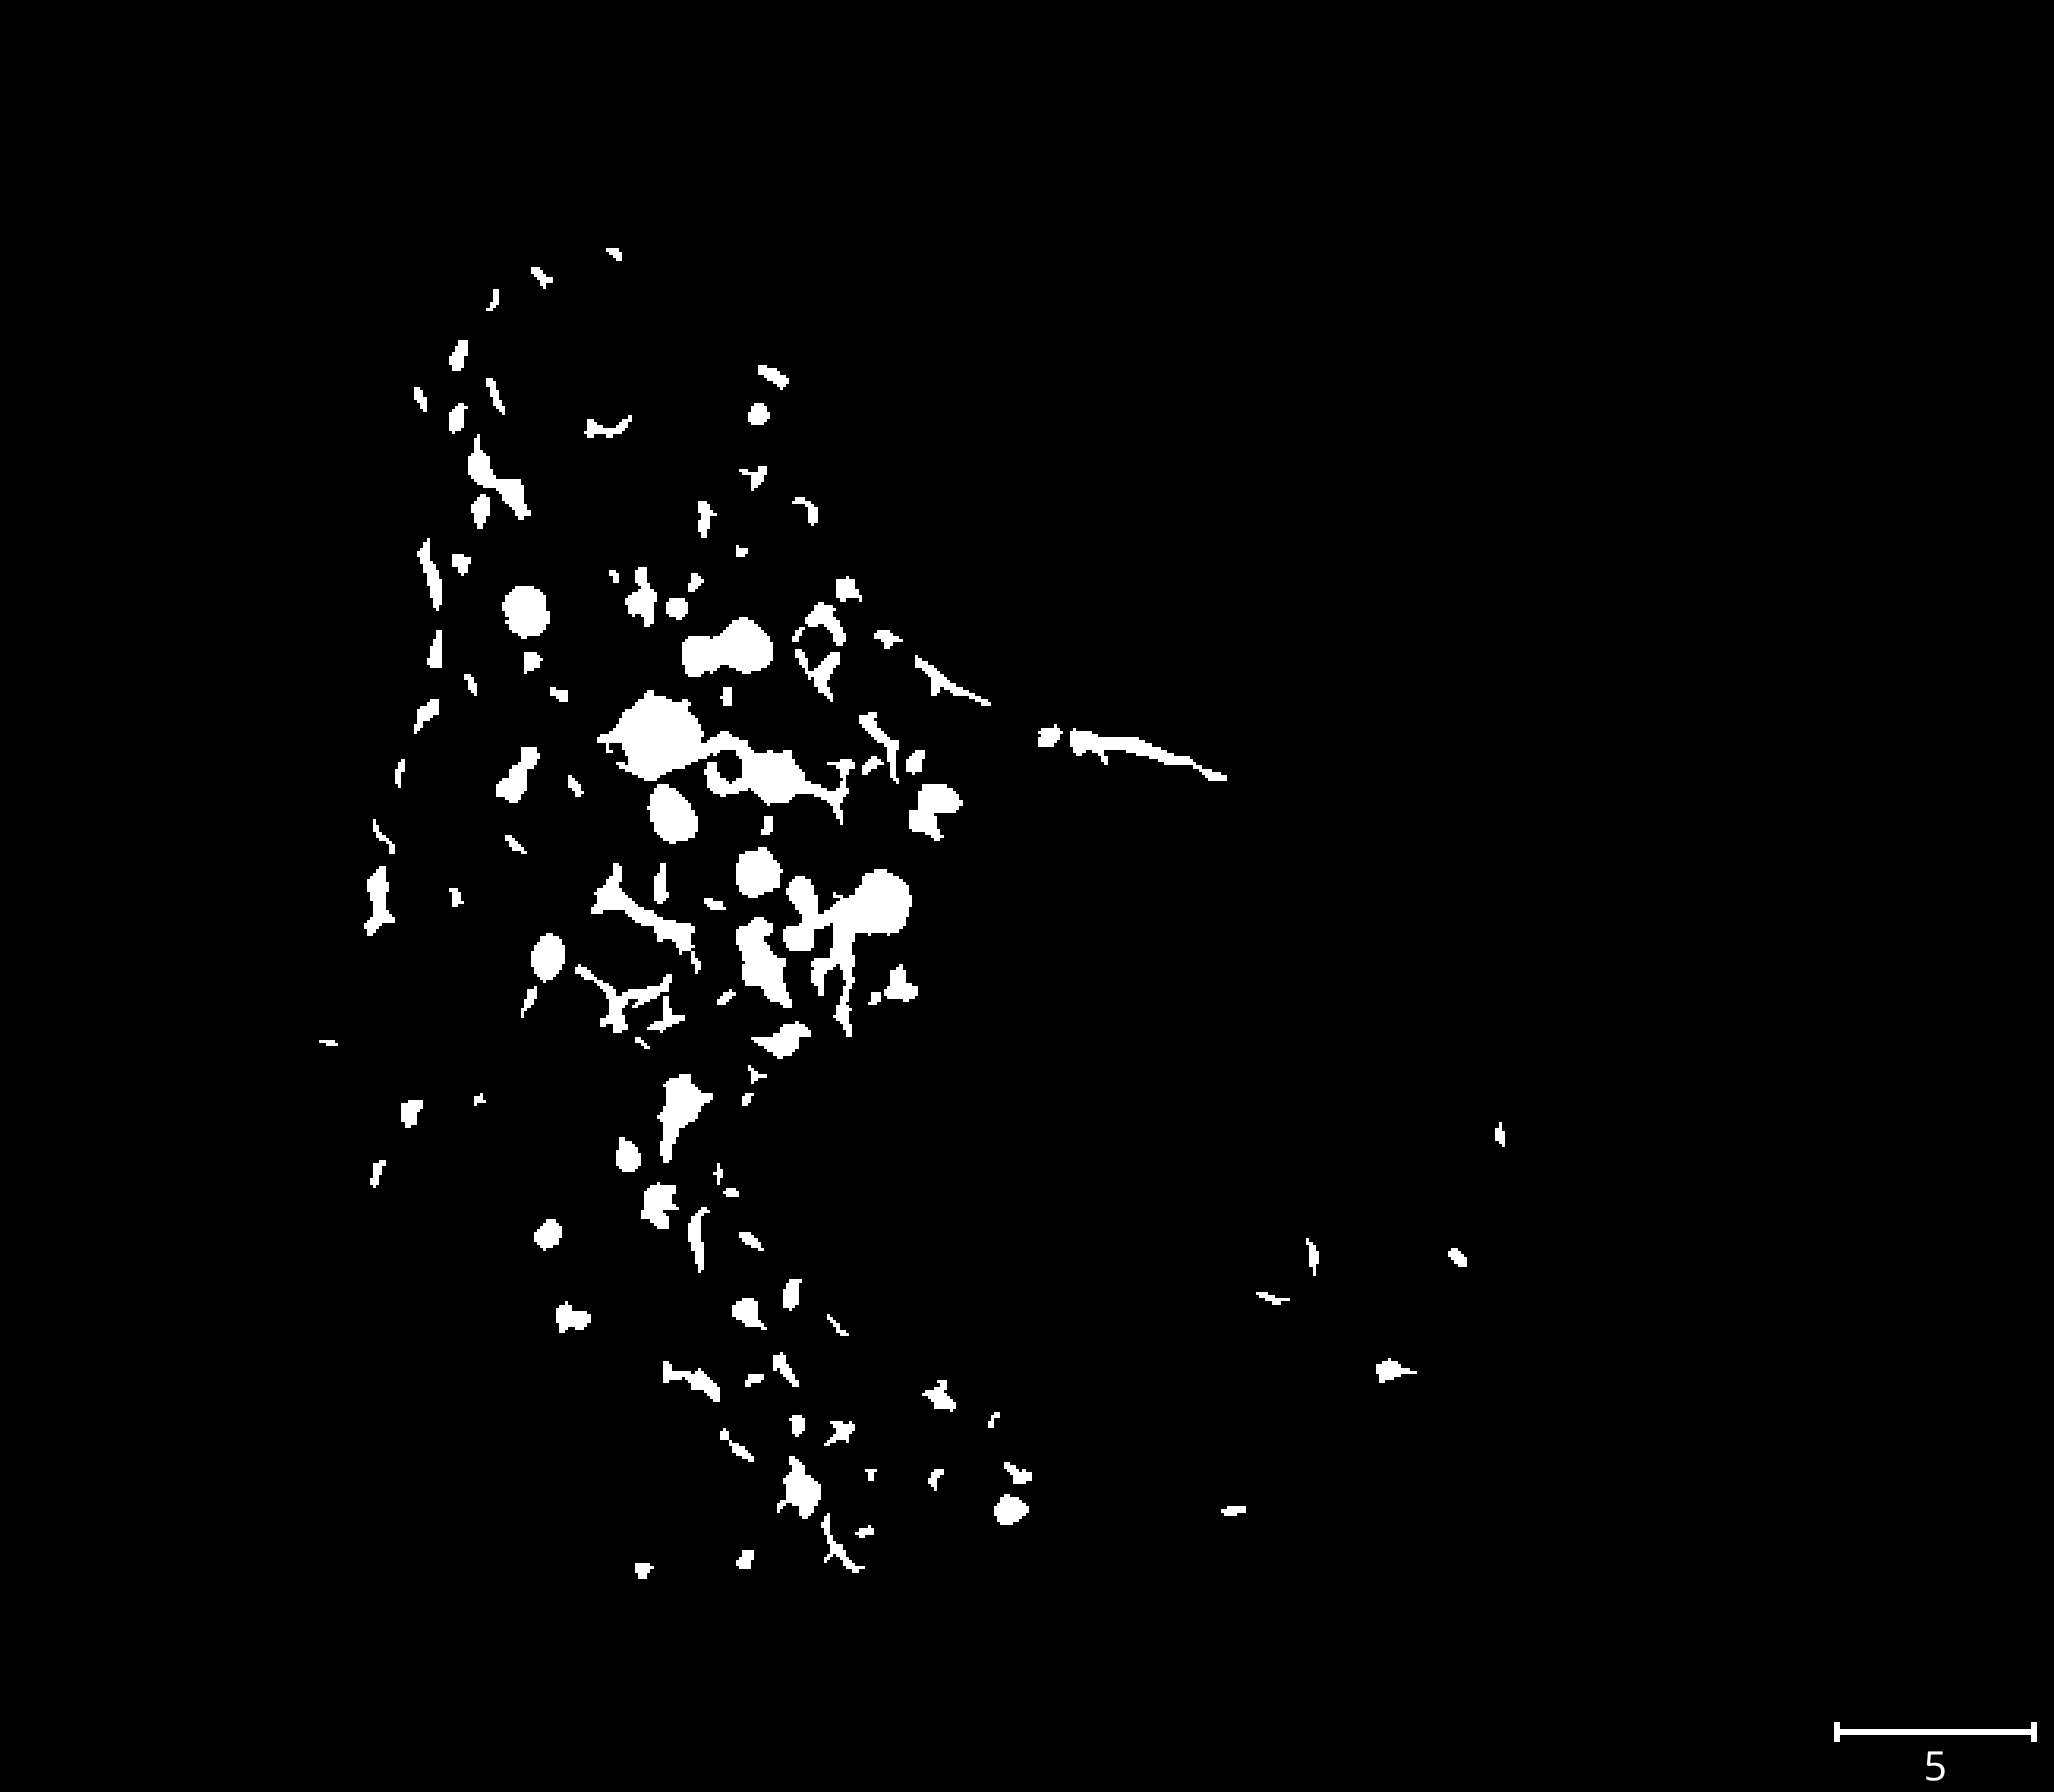

In [33]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)